<a href="https://colab.research.google.com/github/nicholaskuo/YOLO/blob/main/jolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Andrew R and Nick

In [ ]:
# Imports
import torch
import torchvision
import numpy as np
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import DataLoader
from math import floor

In [ ]:
# Downloading and loading training/testing data into DataLoaders
image_transformations = torchvision.transforms.Compose(
                                                  [Resize((448, 448)),
                                                  ToTensor()])
train_data = torchvision.datasets.VOCDetection(
                                        root="data",
                                        year="2007",
                                        image_set="train",
                                        download=True,
                                        transform=image_transformations)
test_data = torchvision.datasets.VOCDetection(
                                        root="data",
                                        year="2007",
                                        image_set="test",
                                        download=True,
                                        transform=image_transformations)
training_data = DataLoader(train_data, batch_size=64, shuffle=True, 
                           collate_fn=lambda x: x) 
testing_data = DataLoader(test_data, batch_size=64, shuffle=True, 
                          collate_fn=lambda x: x)


Extracting data/VOCtrainval_06-Nov-2007.tar to data



Extracting data/VOCtest_06-Nov-2007.tar to data


In [ ]:
# Function for converting training/testing data into a list of batches
# with each batch being a 64x7x7x25 tensor
def processedGroundTruth(dataloader):
  """
  Converts a DataLoader iterable into a list iterable containing batch tensors.

  Arguments:
  dataloader -- torch DataLoader dataset iterable

  Output:
  A list of batches. Each batch is a tensor of size (<=64)x7x7x25.
  (<=64) is the number of images in each batch
  7x7 is all the grid cells per image
  25 is the encoding of ground truth data -- [x_norm, y_norm, w_norm, h_norm, 
                                              20 class probabilities (0 or 1),
                                              objectness score (0 or 1)]
  """
  
  image_batches = [] # numBatches * imgsInBatch * imgSize
  label_batches = [] # numBatches * labelsInBatch * objectsInLabel
  size_batches = [] # numBatches * labelsInBatch * sizeInLabel

  for i, sample in enumerate(dataloader):
    images = []
    labels = []
    sizes = []
    for j in range(len(sample)):
      images.append(sample[j][0])
      labels.append(sample[j][1]["annotation"]["object"])
      sizes.append(sample[j][1]["annotation"]["size"])
    image_batches.append(images)
    label_batches.append(labels)
    size_batches.append(sizes)

  scale_batches = [] # numBatches * imgsInBatch * tuple of (xScale, yScale)
  for i, batch in enumerate(image_batches):
    scale_batch = []
    for j, image in enumerate(batch):
      x_scale = image.size()[2] / int(size_batches[i][j]["width"])
      y_scale = image.size()[1] / int(size_batches[i][j]["height"])
      scale_batch.append((x_scale, y_scale))
    scale_batches.append(scale_batch)

  for i, batch in enumerate(label_batches):
    for j, annotations in enumerate(batch):
      for label in annotations:
        label["bndbox"]["xmin"] = str(round(int(label["bndbox"]["xmin"]) * scale_batches[i][j][0]))
        label["bndbox"]["ymin"] = str(round(int(label["bndbox"]["ymin"]) * scale_batches[i][j][1]))
        label["bndbox"]["xmax"] = str(round(int(label["bndbox"]["xmax"]) * scale_batches[i][j][0]))
        label["bndbox"]["ymax"] = str(round(int(label["bndbox"]["ymax"]) * scale_batches[i][j][1]))

  def bboxData(label):
    x_cen = (int(label["bndbox"]["xmax"]) + int(label["bndbox"]["xmin"])) // 2
    y_cen = (int(label["bndbox"]["ymax"]) + int(label["bndbox"]["ymin"])) // 2
    width = int(label["bndbox"]["xmax"]) - int(label["bndbox"]["xmin"])
    height = int(label["bndbox"]["ymax"]) - int(label["bndbox"]["ymin"])

    x_norm = (x_cen % 64) / 64
    y_norm = (y_cen % 64) / 64

    w_norm = width / 448
    h_norm = height / 448

    grid_x = floor(x_cen / 64)
    grid_y = floor(y_cen / 64)

    name = label["name"]

    return x_norm, y_norm, w_norm, h_norm, grid_x, grid_y, name

  obj_names = {"aeroplane": 4, "bicycle": 5, "bird": 6, "boat": 7, "bottle": 8,
              "bus": 9, "car": 10, "cat": 11, "chair": 12, "cow": 13, 
              "dog": 14, "horse": 15, "motorbike": 16, "person": 17,
              "sheep": 18, "sofa": 19, "diningtable": 20, "pottedplant": 21,
              "train": 22, "tvmonitor": 23}

  ground_truth_batches = [] # numBatches * imgsInBatch * 7x7x25 tensor
  for i, batch in enumerate(image_batches):
    encoding_batch = []
    for j, image in enumerate(batch):
      encoding_tensor = torch.zeros(7, 7, 25)
      annotation = label_batches[i][j]
      for label in annotation:
        bbox = bboxData(label)
        for row in range(7):
          for column in range(7):
            if row == bbox[4] and column == bbox[5]:
              encoding_tensor[row][column][0] = bbox[0]
              encoding_tensor[row][column][1] = bbox[1]
              encoding_tensor[row][column][2] = bbox[2]
              encoding_tensor[row][column][3] = bbox[3]
              encoding_tensor[row][column][obj_names[bbox[-1]]] = 1
              encoding_tensor[row][column][24] = 1
            else:
              pass
      encoding_batch.append(encoding_tensor)
    ground_truth_batches.append(encoding_batch)

  ground_truth_tensor_batches = [] # list of batches, each batch is a 64x7x7x25 tensor
  for batch in ground_truth_batches:
    ground_truth_tensor_batch = torch.stack(batch)
    ground_truth_tensor_batches.append(ground_truth_tensor_batch)

  return image_batches, ground_truth_tensor_batches

In [ ]:
# Converting training/testing data to list of batch tensors.
from time import time
start = time()
processed_training_data = processedGroundTruth(training_data)
end = time()
print(end-start)
# processed_testing_data = processedGroundTruth(testing_data)
# print(time()-end)


21.34610366821289



 torch.Size([7, 7, 25])
person
person
bottle


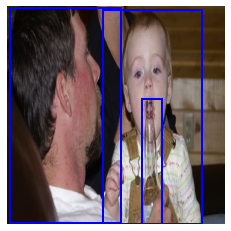


 torch.Size([7, 7, 25])
person
person


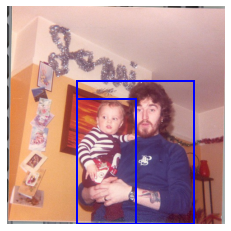


 torch.Size([7, 7, 25])
person
horse
person
horse


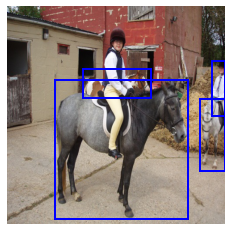

In [ ]:
# Plotting bbox with only ground truth 7x7x25 tensor
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def gtPlot(IMG_NUM=0):
  img = processed_training_data[0][0][IMG_NUM].permute(1, 2, 0).numpy()

  fig, ax = plt.subplots()
  ax.axis("off")
  plt.title("")

  ground = processed_training_data[1][0][IMG_NUM]
  print("\n", ground.size())

  obj_names = {"aeroplane": 4, "bicycle": 5, "bird": 6, "boat": 7, "bottle": 8,
              "bus": 9, "car": 10, "cat": 11, "chair": 12, "cow": 13, 
              "dog": 14, "horse": 15, "motorbike": 16, "person": 17,
              "sheep": 18, "sofa": 19, "diningtable": 20, "pottedplant": 21,
              "train": 22, "tvmonitor": 23}
  find_name = {y:x for x,y in obj_names.items()}

  for row in range(7):
    for col in range(7):
      if ground[row][col][24] == 1:
        bbox_cell = (row, col)
        x_grid_offset = ground[row][col][0] * 64
        y_grid_offset = ground[row][col][1] * 64
        width = ground[row][col][2] * 448
        height = ground[row][col][3] * 448
        x = bbox_cell[0] * 64 + x_grid_offset
        y = bbox_cell[1] * 64 + y_grid_offset
        rect = patches.Rectangle((x-width/2, y-height/2), width, height, 
                                linewidth=2, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        ax.imshow(img)
        for i in range(4, 24):
          if ground[row][col][i] == 1:
            name = find_name[i]
        print(name)

  plt.show()

for i in range(3):
  gtPlot(i)

# Tyler

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms


In [ ]:
#mobile net v1 and v2. Resnet 18, 50
class FeatureExtractor(nn.Module):
  def __init__(self, model, outSize):
    super(FeatureExtractor, self).__init__()
    self.features = list(model.features)
    self.features = nn.Sequential(*self.features)
    self.flatten = nn.Flatten()
    self.fc = model.classifier[0]
    self.outSize = outSize

  def forward(self, x):
    x = self.features(x)
    #x = self.pooling(x)
    x = self.flatten(x)
    out = self.fc(x)
    return out

class FeatureExtractorResnet(nn.Module):
  def __init__(self, model, outSize = 4*25088):
    super(FeatureExtractorResnet, self).__init__()
    self.conv1 = model.conv1
    self.bn1 = model.bn1
    self.relu1 = model.relu
    self.maxpool = model.maxpool
    self.layer1 = model.layer1
    self.layer2 = model.layer2
    self.layer3 = model.layer3
    self.layer4 = model.layer4
   
    self.flatten = nn.Flatten()
    self.outSize = outSize

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    print(x.size())
    x = self.flatten(x)
    print(x.size())
    return x


class PretrainedYolo(nn.Module):
  def __init__(self, featureExtractor, B, S, C):
    super(PretrainedYolo, self).__init__()
    self.features = featureExtractor
    self.head = nn.Linear(featureExtractor.outSize, S * S * (B * 5 + C))

  def forward(self, x):
    x = x.float()
    f = self.features(x)
    out = self.head(f)
    out = nn.ReLU()(out)
    return out

# Un-comment the feature extractor you want

# VGG 16 Model
#vgg = models.vgg16_bn(pretrained = True)
#features = FeatureExtractor(vgg, 4096)

# Mobile Net V2 Model
#mobileNetV2 = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=True)
#features = FeatureExtractor(mobileNetV2, 62720)

# resnet Model
resnet = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=True)
features = FeatureExtractorResnet(resnet)

# Building the Model
apple = PretrainedYolo(features, 1, 7, 20).float()

#print(apple)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


In [ ]:
import numpy as np
testDummy = torch.tensor(np.ones((8, 3, 448, 448)), dtype = torch.double)
print(testDummy.size())
guess = apple(testDummy)
print(guess.size())

torch.Size([8, 3, 448, 448])
torch.Size([8, 512, 14, 14])
torch.Size([8, 100352])
torch.Size([8, 1225])


# Andrew G

In [ ]:
# imports
import os
import numpy as np
import torch
import torchvision
import torch.utils.tensorboard as tb
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, datasets
from torch import nn, optim
from matplotlib import pyplot as plt

from torch import save
from torch import load
from os import path

In [ ]:
# hyperparameters
class Args(object):
  learning_rate = 10**-3 # initial learning rate
  epochs = 10 # total number of epochs
  criterion = nn.MSELoss(reduction='none') # loss metric (not the full equation for computing loss)

  log_dir = 'logdir' # directory for data logging
  model_name = 'jolov1'
  train_logger = tb.SummaryWriter(os.path.join(log_dir, 'train')) # training performance data logger
  valid_logger = tb.SummaryWriter(os.path.join(log_dir, 'test')) # validation performance data logger
  writer = SummaryWriter() # tensorboard writer

  B = 2 # Number of Bounding Boxes predicted for each gridcell
  S = 7 # SxS Grid
  C = 20 # Number of Classes to predict

In [ ]:
# Initialize TensorBoard to visualize/organize training
%reload_ext tensorboard
%tensorboard --logdir {'logdir'} #Launch tensorboard

In [ ]:
# loss function:

class JOLOLoss(nn.Module):

  def __init__(self, args):
    self.args = args
    self.width = 448
    self.cell_width = torch.int(self.width / self.args.S)


  def computeIOU(self, bb1, bb1_cell, bb2, bb2_cell):
    '''
    input:
      bb1 - this is the first bounding box tuple of (x,y,w,h), where x,y is normalized to the gridcell and w,h is normalized to the image
      bb1_cell - this is the tuple of (r,c) for the position of the bb1 center in the S x S grid
      bb2 - this is the second bounding box tuple of (x,y,w,h), where x,y is normalized to the gridcell and w,h is normalized to the image
      bb2_cell - this is the tuple of (r,c) for the position of the bb2 center in the S x S grid
    
    output:
      iou - this is the Intersection over Union (IoU) of the two boxes
    '''

    # compute the top left and bottom right coords of each bounding box
    x1, y1, w1, h1 = bb1
    r1, c1 = bb1_cell
    x1 = (x1*self.cell_width)*c1 # transform coordinates back to pixels
    y1 = (y1*self.cell_width)*r1
    w1 = w1*self.width
    h1 = h1*self.width

    x2, y2, w2, h2 = bb2
    r2, c2 = bb2_cell
    x2 = (x2*self.cell_width)*c2 # transform coordinates back to pixels
    y2 = (y2*self.cell_width)*r2
    w2 = w2*self.width
    h2 = h2*self.width

    x1_tl = x1 - w1 / 2 # for the top left corner of bb1
    y1_tl = y1 - h1 / 2
    x1_br = x1 + w1 / 2 # for the bottom right corner of bb1
    y1_br = y1 + h1 / 2

    x2_tl = x2 - w2 / 2 # for the top left corner of bb2
    y2_tl = y2 - h2 / 2
    x2_br = x2 + w2 / 2 # for the bottom right corner of bb2
    y2_br = y2 + h2 / 2
    
    # find the area of intersection between bb1 and bb2
    xint_tl = max(x1_tl, x2_tl) # for the top left corner of intersection area
    yint_tl = max(y1_tl, y2_tl)
    xint_br = max(x1_br, x2_br) # for the bottom right corner of intersection area
    yint_br = max(y1_br, y2_br)
    intersection_area = max(0, xint_tl - xint_br + 1)*max(0, yint_tl - yint_br + 1)

    iou = intersection_area / (w1*h1 + w2*h2 - intersection_area)

    return iou

  def forward(self, outputs, labels):
    '''
    input:
      outputs - this is the batched output of our model, size: (batch_size x S x S x (5*B + C)) or (64 x 7 x 7 x 30)
      labels - this is the batch of ground truth labels, size: (batch_size x S x S x (TBD)) or (64 x 7 x 7 x (TBD))
    
    output:
      loss - this is the piecewise loss from the YOLO paper, size: (batch_size x ) or (64 x )
    '''

    # model outputs, x, y, w, h, and c size: (batch_size x S x S), or (64 x 7 x 7)
    x1_hat, y1_hat, w1_hat, h1_hat, c1_hat = outputs[:,:,:,0], outputs[:,:,:,1], torch.sqrt(outputs[:,:,:,2]), torch.sqrt(outputs[:,:,:,3]), outputs[:,:,:,4] # predictions for bounding box1
    x2_hat, y2_hat, w2_hat, h2_hat, c2_hat = outputs[:,:,:,5], outputs[:,:,:,6], torch.sqrt(outputs[:,:,:,7]), torch.sqrt(outputs[:,:,:,8]), outputs[:,:,:,9] # predictions for bounding box2
    classes_hat = outputs[:,:,:,10:] # class predictions for gridcells, size: (batch_size x S x S x C) or (64 x 7 x 7 x 20)

    # ground truth,  x, y, w, and h size: (batch_size x S x S), or (64 x 7 x 7)
    x1, y1, w1, h1 = labels[:,:,:,0], labels[:,:,:,1], torch.sqrt(labels[:,:,:,2]), torch.sqrt(labels[:,:,:,3]) # ground truth for bounding box
    classes = outputs[:,:,:,4:-2] # class ground truth for gridcells, size: (batch_size x S x S x C) or (64 x 7 x 7 x 20)
    presence = labels[:,:,:,-1] # ground truth for if a bounding box center is in a particular cell (1=present, 0=absent), size: (batch_size x S x S) or (64 x 7 x 7)

    # we can make two boolean tensors, one will be ones where c1_hat >= c2_hat and zeros otherwise, while the other will be ones where c1_hat < c_hat and zeros otherwise
    indicator_c1 = torch.where(c1_hat >= c2_hat, torch.tensor([1], requires_grad=True), torch.tensor([0], requires_grad=True)) # c1_hat >= c2_hat, size: (batch_size x S x S) or (64 x 7 x 7)
    indicator_c2 = torch.where(c1_hat < c2_hat, torch.tensor([1], requires_grad=True), torch.tensor([0], requires_grad=True)) # c1_hat < c2_hat, size: (batch_size x S x S) or (64 x 7 x 7)


    pos_loss_1 = self.args.criterion(x1, x1_hat) # for bounding box1
    pos_loss_1 += self.args.criterion(y1, y1_hat)
    pos_loss_1 = pos_loss_1 * indicator_c1 # apply indicator variable to all elements
    pos_loss_2 += self.args.criterion(x1, x2_hat) # for bounding box2
    pos_loss_2 += self.args.criterion(y1, y2_hat)
    pos_loss_2 = pos_loss_2 * indicator_c2 # apply indicator variable to all elements
    pos_loss = pos_loss_1 + pos_loss_2
    pos_loss_ = torch.sum(pos_loss, (1, 2)) # MSE loss for position of bounding boxes, size: (64 x )

    dim_loss_1 = self.args.criterion(w1, w1_hat) # for bounding box1
    dim_loss_1 += self.args.criterion(h1, h1_hat)
    dim_loss_1 = dim_loss_1 * indicator_c1 # apply indicator variable to all elements
    dim_loss_2 += self.args.criterion(w1, w2_hat) # for bounding box2
    dim_loss_2 += self.args.criterion(h1, h2_hat)
    dim_loss_2 = dim_loss_2 * indicator_c2 # apply indicator variable to all elements
    dim_loss = dim_loss_1 + dim_loss_2
    dim_loss = torch.sum(dim_loss, (1, 2)) # MSE loss for dimension of bounding boxes, size: (64 x )
    
    class_loss_obj = self.args.criterion(classes, classes_hat) # for object present in cells
    class_loss_obj = torch.sum(class_loss_obj, 3) # yields a tensor of size: (batch_size x S x S), or (64 x 7 x 7)
    class_loss_obj = torch.sum(class_loss_obj * presence, (1, 2)) # MSE loss for class probabilities of each gridcell, size: (64 x )

    class_loss_noobj = self.args.lambda_noobj*self.args.criterion(classes, classes_hat) # for object absent in cells
    class_loss_noobj = torch.sum(class_loss_noobj, 3) # yields a tensor of size: (batch_size x S x S), or (64 x 7 x 7)
    absence = torch.where(presence > 0, torch.tensor([0], requires_grad=True), torch.tensor([1], requires_grad=True)) # compliment of presence
    class_loss_noobj = torch.sum(class_loss_noobj * absence, (1, 2)) # MSE loss for empty gridcells, size: (64 x )
    
    confidence_loss = self.args.criterion(classes, classes_hat)
    confidence_loss = torch.sum(confidence_loss, 3) # yields a tensor of size: (batch_size x S x S) or (64 x 7 x 7)
    confidence_loss = confidence_loss * presence # apply indicator variable to all elements
    confidence_loss = torch.sum(confidence_loss, (1, 2)) # MSE loss for class probabilities of bounding boxes, size: (64 x )


    loss = self.args.lambda_coord*(pos_loss + dim_loss) + confidence_loss
    return loss

In [ ]:
# loss function for B = 1 (a little bit simpler)

class JOLOLossSimple(nn.Module):

  def __init__(self, args):
    self.args = args
    self.width = 448
    self.cell_width = torch.int(width / self.args.S)

  def computeIOU(self, bb1, bb2, anchor):
    '''
    input:
      bb1 - this is the first bounding box tuple of (x,y,w,h), where x,y is normalized to the gridcell and w,h is normalized to the image
      bb2 - this is the second bounding box tuple of (x,y,w,h), where x,y is normalized to the gridcell and w,h is normalized to the image
      anchor - this is the tuple of (r,c) for the position of the anchor center in the S x S grid
    
    output:
      iou - this is the Intersection over Union (IoU) of the two boxes
    '''

    # compute the top left and bottom right coords of each bounding box
    x1, y1, w1, h1 = bb1
    r, c = anchor
    x1 = (x1*self.cell_width)*c # transform coordinates back to pixels
    y1 = (y1*self.cell_width)*r
    w1 = w1*self.width
    h1 = h1*self.width

    x2, y2, w2, h2 = bb2
    x2 = (x2*self.cell_width)*c # transform coordinates back to pixels
    y2 = (y2*self.cell_width)*r
    w2 = w2*self.width
    h2 = h2*self.width

    x1_tl = x1 - w1 / 2 # for the top left corner of bb1
    y1_tl = y1 - h1 / 2
    x1_br = x1 + w1 / 2 # for the bottom right corner of bb1
    y1_br = y1 + h1 / 2

    x2_tl = x2 - w2 / 2 # for the top left corner of bb2
    y2_tl = y2 - h2 / 2
    x2_br = x2 + w2 / 2 # for the bottom right corner of bb2
    y2_br = y2 + h2 / 2
    
    # find the area of intersection between bb1 and bb2
    xint_tl = max(x1_tl, x2_tl) # for the top left corner of intersection area
    yint_tl = max(y1_tl, y2_tl)
    xint_br = max(x1_br, x2_br) # for the bottom right corner of intersection area
    yint_br = max(y1_br, y2_br)
    intersection_area = max(0, xint_tl - xint_br + 1)*max(0, yint_tl - yint_br + 1)

    iou = intersection_area / (w1*h1 + w2*h2 - intersection_area)

    return iou

  def forward(self, input, target):
    # model outputs, x, y, w, h, and c size: (batch_size x S x S), or (64 x 7 x 7)
    x_hat, y_hat, w_hat, h_hat, p_hat = outputs[:,:,:,0], outputs[:,:,:,1], torch.sqrt(outputs[:,:,:,2]), torch.sqrt(outputs[:,:,:,3]), outputs[:,:,:,4] # predictions for bounding box
    classes_hat = outputs[:,:,:,5:] # class predictions for gridcells, size: (batch_size x S x S x C) or (64 x 7 x 7 x 20)

    # ground truth, x, y, w, and h size: (batch_size x S x S), or (64 x 7 x 7)
    x, y, w, h = labels[:,:,:,0], labels[:,:,:,1], torch.sqrt(labels[:,:,:,2]), torch.sqrt(labels[:,:,:,3]) # ground truth for bounding box
    classes = outputs[:,:,:,4:-2] # class ground truth for gridcells, size: (batch_size x S x S x C) or (64 x 7 x 7 x 20)
    presence = labels[:,:,:,-1] # ground truth for if a bounding box center is in a particular cell (1=present, 0=absent), size: (batch_size x S x S) or (64 x 7 x 7)

    pos_loss = self.args.criterion(x, x_hat) # for bounding box1
    pos_loss += self.args.criterion(y, y_hat)
    pos_loss = torch.sum(pos_loss * presence, (1, 2)) # MSE loss for position of bounding boxes, size: (64 x )

    dim_loss = self.args.criterion(w, w_hat) # for bounding box1
    dim_loss += self.args.criterion(h, h_hat)
    dim_loss = torch.sum(dim_loss * presence, (1, 2)) # MSE loss for dimension of bounding boxes, size: (64 x )

    class_loss_obj = self.args.criterion(classes, classes_hat) # for object present in cells
    class_loss_obj = torch.sum(class_loss_obj, 3) # sum for all classes, size: (batch_size x S x S), or (64 x 7 x 7)
    class_loss_obj = torch.sum(class_loss_obj * presence, (1, 2)) # MSE loss for class probabilities in filled gridcell, size: (64 x )

    class_loss_noobj = self.args.lambda_noobj*self.args.criterion(classes, classes_hat) # for object absent in cells
    class_loss_noobj = torch.sum(class_loss_noobj, 3) # yields a tensor of size: (batch_size x S x S), or (64 x 7 x 7)
    absence = torch.where(presence > 0, torch.tensor([0], requires_grad=True), torch.tensor([1], requires_grad=True)) # compliment of presence
    class_loss_noobj = torch.sum(class_loss_noobj * absence, (1, 2)) # MSE loss for class probabilities in empty gridcells, size: (64 x )

    confidences = torch.zeros(self.args.batch_size, self.args.S, self.args.S, requires_grad=True)
    for i,sample in enumerate(p_hat):
      for j,row in enumerate(sample):
        for k,cell in enumerate(row):
          if (presence[i,j,k]):
            rc = (j,k) # anchor position
            bb1 = (x_hat[i,j,k], y_hat[i,j,k], w_hat[i,j,k], h_hat[i,j,k]) # predicted bounding box (x, y, w, h)
            bb2 = (x[i,j,k], y[i,j,k], w[i,j,k], h[i,j,k]) # ground truth bounding box (x, y, w, h)
            confidences[i,j,k] = torch.float(cell)*self.compute_iou(bb1, bb2, rc)
    
    confidence_loss = self.args.criterion(confidences, presence)
    confidence_loss = torch.sum(confidence_loss * presence, (1, 2)) # MSE loss for confidence score in filled gridcells, size: (64 x )

    loss = self.args.lambda_coord*(pos_loss + dim_loss) + class_loss_obj + class_loss_noobj + confidence_loss

    return loss

In [ ]:
# training function:
def train(args):
  
  optimizer = optim.SGD(apple.parameters(), lr=args.learning_rate, momentum=0.9, weight_decay=0.0005) # optimizer

  # Create subfolders to save the tensorboard log files
  if not os.path.exists(path.join(args.log_dir, f'train/{args.model_name}')):
      os.makedirs(path.join(args.log_dir, f'train/{args.model_name}'))
  if not os.path.exists(path.join(args.log_dir, f'valid/{args.model_name}')):
      os.makedirs(path.join(args.log_dir, f'valid/{args.model_name}'))

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  for epoch in range(args.epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    images = processed_training_data[0]
    labels = processed_training_data[1]
    for i, im_batch in enumerate(images):
        im_batch = torch.stack(im_batch, 0)

        # get the inputs: [images, labels]
        im_batch, label_batch = im_batch.to(device), labels[i].to(device)

        print(im_batch.size())
        print(label_batch.size())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = apple(im_batch) # Output produced should be a 7x7x30 tensor (for each gridcell in an image, we'd like to have 30 outputs)
        print(outputs.size())
        print()

        #loss = torch.mean(JOLOLossSimple(args, outputs, labels))
        #loss.backward()
        #optimizer.step()

        #print('Current Epoch: ' + str(epoch))
        #print('Loss at Current Epoch: ' + str(loss))

        # Tensorboard Logging
        #train_logger.add_scalar('Train/loss', loss, epoch) 

        # print statistics
        #running_loss += loss.item()
        # if i % 10 == 9:    # print every 1000 mini-batches
            #print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 1000))
            #running_loss = 0.0

In [ ]:
# runner
args = Args();
train(args)

torch.Size([64, 3, 448, 448])
torch.Size([64, 7, 7, 25])
torch.Size([64, 3, 448, 448])
torch.Size([64, 7, 7, 25])
torch.Size([64, 3, 448, 448])


# Final Product

In [ ]:
# Connecting to gdrive folder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Imports
from math import floor
import numpy as np
from matplotlib import pyplot as plt
from time import time
import os
from os import path
import gc

import torch
from torch import save, load
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
import torch.utils.tensorboard as tb
from torch.utils.tensorboard import SummaryWriter
from torch.autograd import Variable
from torchvision import datasets, models, transforms, ops
from torchvision.transforms import ToTensor, Resize

First, we handle importing data and preprocessing.  This was led by Andrew Raine and Nick Kuo

In [ ]:
# Function for converting training/testing data into a list of batches
# with each batch being a 64x7x7x25 tensor
def processedGroundTruth(dataloader):
  """
  Converts a DataLoader iterable into a list iterable containing batch tensors.

  Arguments:
  dataloader -- torch DataLoader dataset iterable

  Output:
  A list of batches. Each batch is a tensor of size (<=64)x7x7x25.
  (<=64) is the number of images in each batch
  7x7 is all the grid cells per image
  25 is the encoding of ground truth data -- [x_norm, y_norm, w_norm, h_norm, 
                                              20 class probabilities (0 or 1),
                                              objectness score (0 or 1)]
  """
  
  image_batches = [] # numBatches * imgsInBatch * imgSize
  label_batches = [] # numBatches * labelsInBatch * objectsInLabel
  size_batches = [] # numBatches * labelsInBatch * sizeInLabel

  for i, sample in enumerate(dataloader):
    images = []
    labels = []
    sizes = []
    for j in range(len(sample)):
      images.append(sample[j][0])
      labels.append(sample[j][1]["annotation"]["object"])
      sizes.append(sample[j][1]["annotation"]["size"])
    image_batches.append(images)
    label_batches.append(labels)
    size_batches.append(sizes)

  scale_batches = [] # numBatches * imgsInBatch * tuple of (xScale, yScale)
  for i, batch in enumerate(image_batches):
    scale_batch = []
    for j, image in enumerate(batch):
      x_scale = image.size()[2] / int(size_batches[i][j]["width"])
      y_scale = image.size()[1] / int(size_batches[i][j]["height"])
      scale_batch.append((x_scale, y_scale))
    scale_batches.append(scale_batch)

  for i, batch in enumerate(label_batches):
    for j, annotations in enumerate(batch):
      for label in annotations:
        label["bndbox"]["xmin"] = str(round(int(label["bndbox"]["xmin"]) * scale_batches[i][j][0]))
        label["bndbox"]["ymin"] = str(round(int(label["bndbox"]["ymin"]) * scale_batches[i][j][1]))
        label["bndbox"]["xmax"] = str(round(int(label["bndbox"]["xmax"]) * scale_batches[i][j][0]))
        label["bndbox"]["ymax"] = str(round(int(label["bndbox"]["ymax"]) * scale_batches[i][j][1]))

  def bboxData(label):
    x_cen = (int(label["bndbox"]["xmax"]) + int(label["bndbox"]["xmin"])) // 2
    y_cen = (int(label["bndbox"]["ymax"]) + int(label["bndbox"]["ymin"])) // 2
    width = int(label["bndbox"]["xmax"]) - int(label["bndbox"]["xmin"])
    height = int(label["bndbox"]["ymax"]) - int(label["bndbox"]["ymin"])

    x_norm = (x_cen % 64) / 64
    y_norm = (y_cen % 64) / 64

    w_norm = width / 448
    h_norm = height / 448

    grid_x = floor(x_cen / 64)
    grid_y = floor(y_cen / 64)

    name = label["name"]

    return x_norm, y_norm, w_norm, h_norm, grid_x, grid_y, name

  obj_names = {"aeroplane": 4, "bicycle": 5, "bird": 6, "boat": 7, "bottle": 8,
              "bus": 9, "car": 10, "cat": 11, "chair": 12, "cow": 13, 
              "dog": 14, "horse": 15, "motorbike": 16, "person": 17,
              "sheep": 18, "sofa": 19, "diningtable": 20, "pottedplant": 21,
              "train": 22, "tvmonitor": 23}

  ground_truth_batches = [] # numBatches * imgsInBatch * 7x7x25 tensor
  for i, batch in enumerate(image_batches):
    encoding_batch = []
    for j, image in enumerate(batch):
      encoding_tensor = torch.zeros(7, 7, 25)
      annotation = label_batches[i][j]
      for label in annotation:
        bbox = bboxData(label)
        for row in range(7):
          for column in range(7):
            if row == bbox[4] and column == bbox[5]:
              encoding_tensor[row][column][0] = bbox[0]
              encoding_tensor[row][column][1] = bbox[1]
              encoding_tensor[row][column][2] = bbox[2]
              encoding_tensor[row][column][3] = bbox[3]
              encoding_tensor[row][column][obj_names[bbox[-1]]] = 1
              encoding_tensor[row][column][24] = 1
            else:
              pass
      encoding_batch.append(encoding_tensor)
    ground_truth_batches.append(encoding_batch)

  ground_truth_tensor_batches = [] # list of batches, each batch is a 64x7x7x25 tensor
  for batch in ground_truth_batches:
    ground_truth_tensor_batch = torch.stack(batch)
    ground_truth_tensor_batches.append(ground_truth_tensor_batch)

  return image_batches, ground_truth_tensor_batches

In [ ]:
def load_train_data():
  image_transformations = transforms.Compose(
                                          [Resize((448, 448)),
                                          ToTensor()])
  train_data = datasets.VOCDetection(
                                  root="/content/drive/Shareddrives/Summer 2021 Research Project (Dr. Jianbo Shi)",
                                  year="2007",
                                  image_set="train",
                                  download=False,
                                  transform=image_transformations)
  training_data = DataLoader(train_data, batch_size=8, shuffle=True, 
                            collate_fn=lambda x: x) 
  
  # Converting training data to list of batch tensors.
  start = time()
  train_image_batches, train_ground_truth_batches = processedGroundTruth(training_data)
  end = time()
  print('Training Data Processed, time: ' + str(end-start) + ' s')

  train = []
  for i in range(len(train_image_batches)):
    train.append([train_image_batches[i], train_ground_truth_batches[i]])
  return DataLoader(train)

In [ ]:
# Create dataloader for training
trainloader = load_train_data()

In [ ]:
def load_test_data():
  image_transformations = transforms.Compose(
                                          [Resize((448, 448)),
                                          ToTensor()])
  test_data = datasets.VOCDetection(
                                  root="/content/drive/Shareddrives/Summer 2021 Research Project (Dr. Jianbo Shi)",
                                  year="2007",
                                  image_set="test",
                                  download=True,
                                  transform=image_transformations)
  testing_data = DataLoader(test_data, batch_size=8, shuffle=True, 
                            collate_fn=lambda x: x)
  
  # Converting training data to list of batch tensors.
  start = time()
  test_image_batches, test_ground_truth_batches = processedGroundTruth(testing_data)
  end = time()
  print('Testing Data Processed, time: ' + str(end-start) + ' s')

  test = []
  for i in range(len(test_image_batches)):
    test.append([test_image_batches[i], test_ground_truth_batches[i]])
  return DataLoader(test)

In [ ]:
# Create dataloader for testing
testloader = load_test_data()

In [ ]:
torch.cuda.is_available()

True

Now that we have batched data (inputs and ground truth), we can construct the model (backbone and head).  This was led by Tyler Edwards.

In [ ]:
#mobile net v1 and v2. Resnet 18, 50
class FeatureExtractor(nn.Module):
  def __init__(self, model, outSize):
    super(FeatureExtractor, self).__init__()
    self.features = list(model.features)
    self.features = nn.Sequential(*self.features)
    self.flatten = nn.Flatten()
    self.fc = model.classifier[0]
    self.outSize = outSize

  def forward(self, x):
    x = self.features(x)
    #x = self.pooling(x)
    x = self.flatten(x)
    out = self.fc(x)
    return out

class FeatureExtractorResnet(nn.Module):
  def __init__(self, model, outSize = 25088):
    super(FeatureExtractorResnet, self).__init__()
    self.conv1 = model.conv1
    self.bn1 = model.bn1
    self.relu1 = model.relu
    self.maxpool = model.maxpool
    self.layer1 = model.layer1
    self.layer2 = model.layer2
    self.layer3 = model.layer3
    self.layer4 = model.layer4
   
    self.flatten = nn.Flatten()
    self.outSize = outSize

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.maxpool(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.flatten(x)
    print(x.size())
    return x


class PretrainedYolo(nn.Module):
  def __init__(self, featureExtractor, B, S, C):
    super(PretrainedYolo, self).__init__()
    self.features = featureExtractor
    self.head = nn.Linear(featureExtractor.outSize, S * S * (B * 5 + C))

  def forward(self, x):
    x = x.float()
    f = self.features(x)
    out = self.head(f)
    out = nn.ReLU()(out)
    return out

# Un-comment the feature extractor you want

# VGG 16 Model
#vgg = models.vgg16_bn(pretrained = True)
#features = FeatureExtractor(vgg, 4096)

# Mobile Net V2 Model
mobileNetV2 = models.mobilenet_v2(pretrained = True)
features = FeatureExtractor(mobileNetV2, 62720)

# resnet Model
# resnet = models.resnet18(pretrained = True)
# features = FeatureExtractorResnet(resnet)

# Building the Model
apple = PretrainedYolo(features, 1, 7, 20).float()

#print(apple)

With a pretrained model and appropriately formatted data, we can now train JOLO for object detection.  This was led by Andrew Garrett.

In [ ]:
# Assigning Hyperparameters
class Args(object):
  learning_rate = 10**-3 # initial learning rate
  epochs = 160 # total number of epochs
  batch_size = 8 # batch size
  criterion = nn.MSELoss(reduction='none') # loss metric (not the full equation for computing loss)

  log_dir = 'logdir' # directory for data logging
  model_name = 'jolov1'
  train_logger = tb.SummaryWriter(os.path.join(log_dir, 'train')) # training performance data logger
  valid_logger = tb.SummaryWriter(os.path.join(log_dir, 'test')) # validation performance data logger
  writer = SummaryWriter() # tensorboard writer
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  B = 1 # Number of Bounding Boxes predicted for each gridcell
  S = 7 # SxS Grid
  C = 20 # Number of Classes to predict
  lambda_noobj = 0.5
  lambda_coord = 5

  width = 448 # width and height of images
  cell_width = width / S # width and height of gridcells

In [ ]:
def coord_transform(bb, anchor):
  '''
  input:
    bb - bounding box tuple of (x, y, w, h)
    anchor - tuple of (r,c) for the position of the anchor center in the S x S grid

  output:
    bb - bounding box tuple of (x_tl, y_tl, x_br, y_br)
  '''
  x, y, w, h = bb
  r, c = anchor
  x_grid_offset = int(x*args.cell_width) # transform coordinates back to pixels
  y_grid_offset = int(y*args.cell_width)
  w = int(w*args.width)
  h = int(h*args.width)
  x = r*args.cell_width + x_grid_offset
  y = c*args.cell_width + y_grid_offset

  coords = ops.box_convert(torch.tensor([x, y, w, h]), in_fmt='cxcywh', out_fmt='xyxy')

  return coords

In [ ]:
# Define a Loss function for B = 1

class JOLOLossSimple(nn.Module):
  def computeIOU(self, bb1, bb2, anchor):
    '''
    input:
      bb1 - this is the first bounding box tuple of (x,y,w,h), where x,y is normalized to the gridcell and w,h is normalized to the image
      bb2 - this is the second bounding box tuple of (x,y,w,h), where x,y is normalized to the gridcell and w,h is normalized to the image
      anchor - this is the tuple of (r,c) for the position of the anchor center in the S x S grid
    
    output:
      iou - this is the Intersection over Union (IoU) of the two boxes
    '''

    coords1 = coord_transform(bb1, anchor)
    coords2 = coord_transform(bb2, anchor)
    iou_torch = ops.box_iou(torch.unsqueeze(coords1, 0), torch.unsqueeze(coords1, 0))

    return iou_torch.item()

  def forward(self, outputs, labels):
    '''
    input:
      outputs - the batched output of our network
      labels - the batched ground truth

    output:
      loss - the MSE yolo loss
    '''
    # model outputs, x, y, w, h, and c, size: (batch_size x S x S), or (64 x 7 x 7)
    x_hat, y_hat, w_hat, h_hat, p_hat = outputs[:,:,:,0], outputs[:,:,:,1], outputs[:,:,:,2], outputs[:,:,:,3], outputs[:,:,:,4]
    classes_hat = outputs[:,:,:,5:] # class predictions for gridcells, size: (batch_size x S x S x C) or (64 x 7 x 7 x 20)

    # ground truth, x, y, w, and h, size: (batch_size x S x S), or (64 x 7 x 7)
    x, y, w, h = labels[:,:,:,0], labels[:,:,:,1], labels[:,:,:,2], labels[:,:,:,3]
    classes = outputs[:,:,:,4:-1] # class ground truth for gridcells, size: (batch_size x S x S x C) or (64 x 7 x 7 x 20)
    presence = labels[:,:,:,-1] # objectness ground truth (1=present, 0=absent), size: (batch_size x S x S) or (64 x 7 x 7)

    pos_loss = args.criterion(x, x_hat)
    pos_loss += args.criterion(y, y_hat)
    pos_loss = torch.sum(pos_loss * presence, (1, 2)) # MSE loss for position of bounding boxes, size: (64 x )

    dim_loss = args.criterion(w, w_hat)
    dim_loss += args.criterion(h, h_hat)
    dim_loss = torch.sum(dim_loss * presence, (1, 2)) # MSE loss for dimension of bounding boxes, size: (64 x )

    class_loss = args.criterion(classes, classes_hat)
    class_loss = torch.sum(class_loss, 3) # sum for all classes, size: (batch_size x S x S), or (64 x 7 x 7)
    class_loss = torch.sum(class_loss * presence, (1, 2)) # MSE loss for class probabilities in filled gridcells, size: (64 x )

    confidences_obj = torch.zeros(p_hat.size(), requires_grad=True).to(args.device)
    absence = torch.where(presence > 0, torch.tensor([0.], requires_grad=True).to(args.device), torch.tensor([1.], requires_grad=True).to(args.device)) # compliment of presence
    confidences_noobj = torch.zeros(p_hat.size(), requires_grad=True).to(args.device)

    for i,sample in enumerate(p_hat):
      for j,row in enumerate(sample):
        for k,cell in enumerate(row):
          rc = (j,k) # gridcell position
          bb1 = (x_hat[i,j,k], y_hat[i,j,k], w_hat[i,j,k], h_hat[i,j,k]) # predicted bounding box (x, y, w, h)
          bb2 = (x[i,j,k], y[i,j,k], w[i,j,k], h[i,j,k]) # ground truth bounding box (x, y, w, h)
          if (presence[i,j,k]):
            confidences_obj[i,j,k].data = cell*self.computeIOU(bb1, bb2, rc)
          else:
            confidences_noobj[i,j,k].data = cell*self.computeIOU(bb1, bb2, rc)
    
    confidence_loss_obj = args.criterion(confidences_obj, presence)
    confidence_loss_obj = torch.sum(confidence_loss_obj * presence, (1, 2)) # MSE loss for confidence score in filled gridcells, size: (64 x )

    confidence_loss_noobj = args.criterion(confidences_noobj, presence)
    confidence_loss_noobj = torch.sum(confidence_loss_noobj * absence, (1, 2)) # MSE loss for confidence score in empty gridcells, size: (64 x )

    print('Jolo (xy MSE Loss): ', str(torch.mean(pos_loss)))
    print('Jolo (wh MSE Loss): ', str(torch.mean(dim_loss)))
    print('Jolo (obj MSE Loss): ', str(torch.mean(confidence_loss_obj)))
    print('Jolo (no_obj MSE Loss): ', str(torch.mean(confidence_loss_noobj)))
    print('Jolo (class MSE Loss): ', str(torch.mean(class_loss)))

    loss = args.lambda_coord*(pos_loss + dim_loss) + class_loss + confidence_loss_obj + args.lambda_noobj*confidence_loss_noobj
    print('Jolo (total MSE Loss): ', str(torch.mean(loss)))
    return torch.mean(loss)

In [ ]:
# Open Source loss function (tweaked to work with our code)
class Loss(nn.Module):

    def __init__(self, feature_size=7, num_bboxes=1, num_classes=20, lambda_coord=5.0, lambda_noobj=0.5):
        """ Constructor.
        Args:
            feature_size: (int) size of input feature map.
            num_bboxes: (int) number of bboxes per each cell.
            num_classes: (int) number of the object classes.
            lambda_coord: (float) weight for bbox location/size losses.
            lambda_noobj: (float) weight for no-objectness loss.
        """
        super(Loss, self).__init__()

        self.S = feature_size
        self.B = num_bboxes
        self.C = num_classes
        self.lambda_coord = lambda_coord
        self.lambda_noobj = lambda_noobj

        self.my_jolo = JOLOLossSimple()


    def compute_iou(self, bbox1, bbox2):
        """ Compute the IoU (Intersection over Union) of two set of bboxes, each bbox format: [x1, y1, x2, y2].
        Args:
            bbox1: (Tensor) bounding bboxes, sized [N, 4].
            bbox2: (Tensor) bounding bboxes, sized [M, 4].
        Returns:
            (Tensor) IoU, sized [N, M].
        """
        N = bbox1.size(0)
        M = bbox2.size(0)

        # Compute left-top coordinate of the intersections
        lt = torch.max(
            bbox1[:, :2].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, :2].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Conpute right-bottom coordinate of the intersections
        rb = torch.min(
            bbox1[:, 2:].unsqueeze(1).expand(N, M, 2), # [N, 2] -> [N, 1, 2] -> [N, M, 2]
            bbox2[:, 2:].unsqueeze(0).expand(N, M, 2)  # [M, 2] -> [1, M, 2] -> [N, M, 2]
        )
        # Compute area of the intersections from the coordinates
        wh = rb - lt   # width and height of the intersection, [N, M, 2]
        wh[wh < 0] = 0 # clip at 0
        inter = wh[:, :, 0] * wh[:, :, 1] # [N, M]

        # Compute area of the bboxes
        area1 = (bbox1[:, 2] - bbox1[:, 0]) * (bbox1[:, 3] - bbox1[:, 1]) # [N, ]
        area2 = (bbox2[:, 2] - bbox2[:, 0]) * (bbox2[:, 3] - bbox2[:, 1]) # [M, ]
        area1 = area1.unsqueeze(1).expand_as(inter) # [N, ] -> [N, 1] -> [N, M]
        area2 = area2.unsqueeze(0).expand_as(inter) # [M, ] -> [1, M] -> [N, M]

        # Compute IoU from the areas
        union = area1 + area2 - inter # [N, M, 2]
        iou = inter / union           # [N, M, 2]

        return iou

    def forward(self, pred_tensor, target_tensor):
        """ Compute loss for YOLO training.
        Args:
            pred_tensor: (Tensor) predictions, sized [n_batch, S, S, Bx5+C], 5=len([x, y, w, h, conf]).
            target_tensor: (Tensor) targets, sized [n_batch, S, S, Bx5+C].
        Returns:
            (Tensor): loss, sized [1, ].
        """
        # TODO: Romove redundant dimensions for some Tensors.

        S, B, C = self.S, self.B, self.C
        N = 5 * B + C    # 5=len([x, y, w, h, conf]

        # Create a boolean mask for target_tensor where gt tensor is all True or all False depending on if object is the cell
        batch_size = pred_tensor.size(0)
        coord_mask = target_tensor[:, :, :, 4] > 0  # mask for the cells which contain objects. [n_batch, S, S] === boolean mask for each grid cell that is true if objectness != 0, else false
        noobj_mask = target_tensor[:, :, :, 4] == 0 # mask for the cells which do not contain objects. [n_batch, S, S] ===boolean mask for each grid cell that is true if objectness == 0, else false
        coord_mask = coord_mask.unsqueeze(-1).expand_as(target_tensor) # [n_batch, S, S] -> [n_batch, S, S, N] === copies over grid cell boolean value to new depth 25 tensor 
        noobj_mask = noobj_mask.unsqueeze(-1).expand_as(target_tensor) # [n_batch, S, S] -> [n_batch, S, S, N] === copies over grid cell boolean value to new depth 25 tensor 

        coord_pred = pred_tensor[coord_mask].view(-1, N)            # pred tensor on the cells which contain objects. [n_coord, N] === only keep pred grid cell tensors where the coord_mask is true
        bbox_pred = coord_pred[:, :5*B].contiguous().view(-1, 5)    # [n_coord x B, 5=len([x, y, w, h, conf])] === gets the bbox data for each valid grid cell in prediction
        class_pred = coord_pred[:, 5*B:]                            # [n_coord, C] === gets the class prob data for each valid grid cell in prediction

        coord_target = target_tensor[coord_mask].view(-1, N)        # target tensor on the cells which contain objects. [n_coord, N] === only keep gt grid cell tensor where the coord_mask is true
        bbox_target = coord_target[:, :5*B].contiguous().view(-1, 5)# [n_coord x B, 5=len([x, y, w, h, conf])] === gets the bbox data for each valid grid cell in truth
        class_target = coord_target[:, 5*B:]                        # [n_coord, C] === gets the class prob data for each valid grid cell in truth

        # Compute loss for the cells with no object bbox.
        noobj_pred = pred_tensor[noobj_mask].view(-1, N)        # pred tensor on the cells which do not contain objects. [n_noobj, N] === only keep pred grid cell tensor if noobj_mask is true
        noobj_target = target_tensor[noobj_mask].view(-1, N)    # target tensor on the cells which do not contain objects. [n_noobj, N] === only keep gt grid cell tensor if noobj_mask is true

        # noobj_conf_mask = torch.cuda.ByteTensor(noobj_pred.size()).fill_(0) # [n_noobj, N]
        noobj_conf_mask = torch.zeros(noobj_pred.size(), dtype=torch.bool).cuda() # === create boolean False mask to filter confidences later

        for b in range(B):
            noobj_conf_mask[:, 4 + b*5] = True # noobj_conf_mask[:, 4] = 1; noobj_conf_mask[:, 9] = 1  === change confidence mask to filter for 4th position in tensor (the confidence)
        noobj_pred_conf = noobj_pred[noobj_conf_mask]       # [n_noobj, 2=len([conf1, conf2])] === keep only the predicted confidences for grid cells with no object
        noobj_target_conf = noobj_target[noobj_conf_mask]   # [n_noobj, 2=len([conf1, conf2])] === keep only the gt confidences for grid cells with no object
        loss_noobj = F.mse_loss(noobj_pred_conf, noobj_target_conf, reduction='sum') # === find error between predicted confidences and gt confidences for grid cells with no object

        # Compute loss for the cells with objects.
        # coord_response_mask = torch.cuda.ByteTensor(bbox_target.size()).fill_(0)    # [n_coord x B, 5]
        coord_response_mask = torch.zeros(bbox_target.size(), dtype=torch.bool).cuda() # === 
        # coord_not_response_mask = torch.cuda.ByteTensor(bbox_target.size()).fill_(1)# [n_coord x B, 5]
        coord_not_response_mask = torch.ones(bbox_target.size(), dtype=torch.bool).cuda() # === 
        bbox_target_iou = torch.zeros(bbox_target.size()).cuda()                    # [n_coord x B, 5], only the last 1=(conf,) is used === 

        # Choose the predicted bbox having the highest IoU for each target bbox.
        for i in range(0, bbox_target.size(0), B): # === looping over all of the grid cells where an object was detected
            pred = bbox_pred[i:i+B] # predicted bboxes at i-th cell, [B, 5=len([x, y, w, h, conf])] === get bbox data for predicted object i
            pred_xyxy = Variable(torch.FloatTensor(pred.size())) # [B, 5=len([x1, y1, x2, y2, conf])] === 
            # Because (center_x,center_y)=pred[:, 2] and (w,h)=pred[:,2:4] are normalized for cell-size and image-size respectively,
            # rescale (center_x,center_y) for the image-size to compute IoU correctly.
            pred_xyxy[:,  :2] = pred[:, :2]/float(S) - 0.5 * pred[:, 2:4]
            pred_xyxy[:, 2:4] = pred[:, :2]/float(S) + 0.5 * pred[:, 2:4]

            target = bbox_target[i] # target bbox at i-th cell. Because target boxes contained by each cell are identical in current implementation, enough to extract the first one.
            target = bbox_target[i].view(-1, 5) # target bbox at i-th cell, [1, 5=len([x, y, w, h, conf])]
            target_xyxy = Variable(torch.FloatTensor(target.size())) # [1, 5=len([x1, y1, x2, y2, conf])]
            # Because (center_x,center_y)=target[:, 2] and (w,h)=target[:,2:4] are normalized for cell-size and image-size respectively,
            # rescale (center_x,center_y) for the image-size to compute IoU correctly.
            target_xyxy[:,  :2] = target[:, :2]/float(S) - 0.5 * target[:, 2:4]
            target_xyxy[:, 2:4] = target[:, :2]/float(S) + 0.5 * target[:, 2:4]

            iou = self.compute_iou(pred_xyxy[:, :4], target_xyxy[:, :4]) # [B, 1]
            max_iou, max_index = iou.max(0)
            max_index = max_index.data.cuda()

            coord_response_mask[i+max_index] = True
            coord_not_response_mask[i+max_index] = False

            # "we want the confidence score to equal the intersection over union (IOU) between the predicted box and the ground truth"
            # from the original paper of YOLO.
            bbox_target_iou[i+max_index, torch.LongTensor([4]).cuda()] = (max_iou).data.cuda()
        bbox_target_iou = Variable(bbox_target_iou).cuda()

        # BBox location/size and objectness loss for the response bboxes.
        # print("coord_response_mask", coord_response_mask.size())
        # print("bbox pred size", bbox_pred.size())
        bbox_pred_response = bbox_pred[coord_response_mask].view(-1, 5)      # [n_response, 5]
        bbox_target_response = bbox_target[coord_response_mask].view(-1, 5)  # [n_response, 5], only the first 4=(x, y, w, h) are used
        target_iou = bbox_target_iou[coord_response_mask].view(-1, 5)        # [n_response, 5], only the last 1=(conf,) is used
        # print(bbox_pred_response[:, :2], bbox_target_response[:, :2])
        loss_xy = F.mse_loss(bbox_pred_response[:, :2], bbox_target_response[:, :2], reduction='sum')
        # print("loss_xy", loss_xy)
        # print("bbox_pred_response[:, 2:4]:", bbox_pred_response[:, 2:4]) #commented out to train
        # print("torch.sqrt(bbox_pred_response[:, 2:4])", torch.sqrt(bbox_pred_response[:, 2:4])) #trying to take sqrt of negative numbers becomes NaN, need to prevent bbox_pred from having negative nums
        # print("torch.sqrt(bbox_target_response[:, 2:4])", torch.sqrt(bbox_target_response[:, 2:4]))
        loss_wh = F.mse_loss(torch.sqrt(bbox_pred_response[:, 2:4]), torch.sqrt(bbox_target_response[:, 2:4]), reduction='sum')
        # print("loss_wh", loss_wh) #commented out to train
        loss_obj = F.mse_loss(bbox_pred_response[:, 4], target_iou[:, 4], reduction='sum')
        # print("loss_obj:", loss_obj)

        # Class probability loss for the cells which contain objects.
        loss_class = F.mse_loss(class_pred, class_target, reduction='sum')
        # print("loss_class:", loss_class)
        print('Github (xy MSE Loss): ', str(loss_xy / float(batch_size)))
        print('Github (wh MSE Loss): ', str(loss_wh / float(batch_size)))
        print('Github (obj MSE Loss): ', str(loss_obj / float(batch_size)))
        print('Github (no_obj MSE Loss): ', str(loss_noobj / float(batch_size)))
        print('Github (class MSE Loss): ', str(loss_class / float(batch_size)))
        # Total loss
        loss = self.lambda_coord * (loss_xy + loss_wh) + loss_obj + self.lambda_noobj * loss_noobj + loss_class
        # print("self.lambda_coord:", self.lambda_coord)
        # print("loss_xy + loss_wh:", loss_xy + loss_wh) #commented out to train
        # print("loss_obj:", loss_obj)
        # print("self.lambda_noobj:", self.lambda_noobj)
        # print("loss_noobj:", loss_noobj)
        # print("loss_class:", loss_class)
        # print("loss:", loss)
        loss = loss / float(batch_size)
        # print("loss2:", loss)
        print('Github (total MSE Loss): ', str(loss))
        self.my_jolo(pred_tensor, target_tensor)
        return loss

# loss_fn = Loss()

# imgs, labels = next(iter(trainloader))
# label = labels[0].cuda()
# # for i in range(7):
# #   for j in range(7):
# #     if label[i][j][24] == 1:
# #       print(label[i][j])

# output = label.clone()
# # output = torch.rand(8, 7, 7, 25).cuda()
# ground = label.clone()
# loss_fn(output, ground)

In [ ]:
args = Args()
outputs = torch.randn(8, 7, 7, 25).to(args.device)
labels = torch.randn(8, 7, 7, 25).to(args.device)
loss = Loss()
loss(outputs, labels)

Github (xy MSE Loss):  tensor(93.5966, device='cuda:0')
Github (wh MSE Loss):  tensor(nan, device='cuda:0')
Github (obj MSE Loss):  tensor(26.8734, device='cuda:0')
Github (no_obj MSE Loss):  tensor(0., device='cuda:0')
Github (class MSE Loss):  tensor(1039.9740, device='cuda:0')
Github (total MSE Loss):  tensor(nan, device='cuda:0')
Jolo (xy MSE Loss):  tensor(0.1878, device='cuda:0')
Jolo (wh MSE Loss):  tensor(6.2559, device='cuda:0')
Jolo (obj MSE Loss):  tensor(-0.6369, device='cuda:0', grad_fn=<MeanBackward0>)
Jolo (no_obj MSE Loss):  tensor(25.9739, device='cuda:0', grad_fn=<MeanBackward0>)
Jolo (class MSE Loss):  tensor(-21.4953, device='cuda:0')
Jolo (total MSE Loss):  tensor(23.0731, device='cuda:0', grad_fn=<MeanBackward0>)


tensor(nan, device='cuda:0')

In [ ]:
# Define a Training Loop
def train(args):
  
  # Create subfolders to save the tensorboard log files
  if not os.path.exists(path.join(args.log_dir, f'train/{args.model_name}')):
      os.makedirs(path.join(args.log_dir, f'train/{args.model_name}'))
  if not os.path.exists(path.join(args.log_dir, f'valid/{args.model_name}')):
      os.makedirs(path.join(args.log_dir, f'valid/{args.model_name}'))

  apple.to(args.device)
  optimizer = optim.SGD(apple.parameters(), lr=args.learning_rate, momentum=0.9, weight_decay=0.0005)
  # loss_eval = JOLOLossSimple()
  loss_eval = Loss()
  loss_arr = []

  for epoch in range(args.epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    num_batches = 0

    for i, (im_batch, label_batch) in enumerate(trainloader, 0):
        im_batch = torch.squeeze(torch.stack(im_batch, 0))
        label_batch = torch.squeeze(label_batch)

        im_batch = im_batch.to(args.device)
        label_batch = label_batch.to(args.device)
        # print(i, im_batch)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output_batch = apple(im_batch) # Output produced should be a 7x7x25 tensor (for each gridcell in an image, we'd like to have 25 outputs)
        output_batch = torch.reshape(output_batch, (-1, args.S, args.S, (5*args.B + args.C)))
        loss = loss_eval(output_batch, label_batch)
        loss.backward()
        optimizer.step()

        print('Current Batch: ' + str(i+1))
        print('Loss at Current Batch (Epoch'+ str(epoch + 1) +'): ' + str(loss.item()))
        print()

        running_loss += loss.item()
        loss_arr.append(loss.item())
        num_batches += 1

    # Tensorboard Logging
    loss_logger = running_loss / num_batches
    args.train_logger.add_scalar('Train/loss', loss_logger, epoch)
    print('Current Batch Running Loss: ' + str(loss_logger))
  args.train_logger.flush()

In [ ]:
args = Args();
# Initialize TensorBoard to visualize/organize training
%reload_ext tensorboard
%tensorboard --logdir {args.log_dir} #Launch tensorboard

In [ ]:
# Training
# train(args)
# torch.save(apple, "/content/drive/Shareddrives/Summer 2021 Research Project (Dr. Jianbo Shi)/model-epochs:" + str(args.epochs) + "-batchsize:" + str(args.batch_size) + ".pth")

After training our network, we perform inference using non-maximal suppresion.

In [ ]:
# Compute NMS for a batched output
def computeNMS(output, confidence_threshold, iou_threshold):
  '''
  input:
    output - the batched output of a forward pass through our network, size: (64 x 7 x 7 x 25)
    confidence_threshold - the threshold for objectness score which filters out bounding boxes with scores below this
    iou_threshold - the threshold for iou used in NMS
  
  output:
    keep - the batched boolean tensor for boxes kept by NMS and highest class probability, size: (64 x 7 x 7)
  '''
  
  coords = output[:,:,:,:4] # retrieve all x,y,w,h coordinates
  scores = output[:,:,:,4] # retrieve all confidence scores
  scores = torch.reshape(scores, (args.batch_size, -1)) # reshape to be inputted into torchvision's nms
  class_probs = output[:,:,:,5:] # retrieve all class probabilities
  class_probs = torch.reshape(class_probs, (args.batch_size, -1, class_probs.size()[3]))

  transformed_coords = torch.zeros(args.batch_size, args.S, args.S, 4).to(args.device) # transform coordinates
  for i, batch in enumerate(coords):
    for j, row in enumerate(batch):
      for k, sample in enumerate(row):
        rc = (j,k)
        bb = (coords[i,j,k,0], coords[i,j,k,1], coords[i,j,k,2], coords[i,j,k,3])
        transformed_coords[i,j,k,:].data = coord_transform(bb, rc)
  coords = torch.reshape(transformed_coords, (args.batch_size, -1, 4)) # reshape to be inputted into torchvision's nms
  
  keep = torch.zeros(scores.size()).to(args.device)
  for i, batch in enumerate(coords):
    # filter by iou threshold and confidence threshold
    nms = ops.nms(batch, scores[i], iou_threshold)
    for j, index in enumerate(nms):
      if scores[i,index] >= confidence_threshold:
        keep[i,index] = 1.0
  keep = torch.reshape(keep, (args.batch_size, args.S, args.S))
  return keep
  
  '''
  # determine the most likely class for each gridcell and create a mask according to confidence threshold
  for i, batch in enumerate(class_probs):
    score_slice = scores[i,:,:]
    for j in range(args.C):
      torch.max(class_slice)
      class_slice = batch[:,:,j]
      idx = (score_slice==best_obj).nonzero()[0]
      if (score_slice[idx[0], idx[1]] >= confidence_threshold):
        keep_class[i,idx[0], idx[1],j] = 1.0
      bounding_boxes[i,:,:] += keep_class[i,:,:,j] * keep[i,:,:]

  
  coords = torch.reshape(coords, (-1, args.S, args.S, 4))
  bounding_boxes = torch.zeros(coords.size())
  for i in range(4):
    bounding_boxes[:,:,:,i] = mask * coords[:,:,:,i]
  
  return keep_class, keep, bounding_boxes
  return keep, coords
  '''

In [ ]:
args = Args();
output = torch.rand(8,7,7,25).to(args.device)
iou_threshold = 0.5
confidence_threshold = 0.6
keep, coords = computeNMS(output, confidence_threshold, iou_threshold)
print(keep.size())
print(keep[0])
print(coords.size())
print(coords[0])

In [ ]:
# Validation
def evaluate(args):

  loss_eval = JOLOLossSimple()
  loss_arr = []

  val_loss = 0.0
  for i, (im_batch, label_batch) in enumerate(testloader, 0):
      im_batch = torch.stack(im_batch, 0)
      im_batch = torch.squeeze(im_batch)
      label_batch = torch.squeeze(label_batch)

      im_batch = im_batch.to(device)
      label_batch = label_batch.to(device)

      output_batch = apple(im_batch) # Output produced should be a 7x7x25 tensor (for each gridcell in an image, we'd like to have 25 outputs)
      output_batch = torch.reshape(output_batch, (-1, args.S, args.S, (5*args.B + args.C)))

      loss = loss_eval(output_batch, label_batch)


# Visualization

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
imb, lab = next(iter(trainloader))
imb = torch.stack(imb)
imb = torch.squeeze(imb).to(device)
lab = torch.squeeze(lab).to(device)

PATH = "/content/drive/Shareddrives/Summer 2021 Research Project (Dr. Jianbo Shi)/workingModel160Epochs.pth"
apple = torch.load(PATH).float()

# vgg = models.vgg16_bn(pretrained = True)
# features = FeatureExtractor(vgg)
# apple = PretrainedYolo(features, 1, 7, 20).float()
# apple.load_state_dict(torch.load("weights160epochs.pth"))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
apple.to(device)

out = apple(imb)
out = torch.reshape(out, (8, 7, 7, 25))
print(imb.size(), lab.size(), out.size())

torch.Size([8, 3, 448, 448]) torch.Size([8, 7, 7, 25]) torch.Size([8, 7, 7, 25])


bird


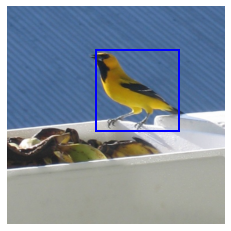

In [ ]:
# Plotting bbox with only ground truth 7x7x25 tensor
import matplotlib.pyplot as plt
import matplotlib.patches as patches

imgb = imb.cpu()
labb = out.cpu()

def gtPlot(IMG_NUM=0):
  img = imgb[IMG_NUM].permute(1, 2, 0).numpy()

  fig, ax = plt.subplots()
  ax.axis("off")
  plt.title("")

  ground = labb[IMG_NUM]
  # print("\n", ground.size())

  obj_names = {"aeroplane": 5, "bicycle": 6, "bird": 7, "boat": 8, "bottle": 9,
              "bus": 10, "car": 11, "cat": 12, "chair": 13, "cow": 14, 
              "dog": 15, "horse": 16, "motorbike": 17, "person": 18,
              "sheep": 19, "sofa": 20, "diningtable": 21, "pottedplant": 22,
              "train": 23, "tvmonitor": 24}
  find_name = {y:x for x,y in obj_names.items()}

  for row in range(7):
    for col in range(7):
      if ground[row][col][4] >= 0.5:
        # # print(ground[row][col])
        max_class = max(ground[row][col][5:].flatten())
        for i in range(5, 25):
          # print(ground[row][col][i].item())
          if ground[row][col][i].item() == max_class:
            name_index = i
        print(find_name[name_index])
        bbox_cell = (row, col)
        x_grid_offset = ground[row][col][0] * 64
        y_grid_offset = ground[row][col][1] * 64
        width = ground[row][col][2] * 448
        height = ground[row][col][3] * 448
        x = bbox_cell[0] * 64 + x_grid_offset
        y = bbox_cell[1] * 64 + y_grid_offset
        rect = patches.Rectangle((x-width/2, y-height/2), width, height, 
                                linewidth=2, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        ax.imshow(img)
      # for i in range(5, 25):
      #   if ground[row][col][4] >= 0.5:
      #     name = find_name[i]
      #     print(name)
      #     if name == "sofa":
      #       print(name, row, col)
      #       bbox_cell = (row, col)
      #       x_grid_offset = ground[row][col][0] * 64
      #       y_grid_offset = ground[row][col][1] * 64
      #       width = ground[row][col][2] * 448
      #       height = ground[row][col][3] * 448
      #       x = bbox_cell[0] * 64 + x_grid_offset
      #       y = bbox_cell[1] * 64 + y_grid_offset
      #       rect = patches.Rectangle((x-width/2, y-height/2), width, height, 
      #                               linewidth=2, edgecolor='b', facecolor='none')
      #       ax.add_patch(rect)
      #       ax.imshow(img)

  plt.show()

gtPlot(3)

# TO DO

  1. Finish a validation/inference function
  2. Develop a visualization function using torchvision.utils.draw_bounding_boxes and self.coord_transform
  3. Debug NMS function, potentially loss function
  4. Figure out some decent hyperparameters

If necessary, we can use functions from existing implementations of yolo.  We need to get this done asap so we can get moving onto other things.